# Lab 3: Extending Logistic Regression

By Yifan Ding

# Preparation and Overview (30 Points Total)

## Business Understanding (20 Points)

This dataset, “Chess Game Dataset Lichess,” is obtained from Kaggle under the CC0: Public Domain license.  Lichess.org is a website where users can play live chess games; the information in the dataset contains information from approximately 21,000 games and includes variables such as outcome (white win, black win, or draw), chess rating for black and white, moves (which allows for a complete record of the game), and time increment.  Lichess has an API which allows for relatively easy collection of the data.

Among the questions that can be explored using this dataset include: (1) “What (if any) is the white advantage given relative ratings and opening position?”, (2) “What are the best moves after a specific opening that lead to victory?”, (3) “Will this position result in a draw?”, and (4) “Who is going to win after the opening?”  The white advantage question can be answered with data visualization.  The best moves question is best answered with a chess engine such as Stockfish.  The draw question is a probability question.  

For this assignment, our question is “Who is most likely to win the game after 5 moves (10 half-moves) of a chess game?”

The prediction task is to predict the winner of a chess match while it is on-going.  The model will be given the metadata of the match, the type of opening, and the first ten half moves of a chess game.  The most obvious use for our data is by gambling websites to set true odds of matches or, alternatively, by individual gamblers to find attractive bets.  The “while on-going” is because many websites are starting to implement live gambling.  If this innovation comes to chess, than similar models will become necessary by gambling websites to update the true odds of who will win.  While the data was compiled on Lichess.com with its own rating system, our model could on any game where the ratings of the players come from the FIDE (International Chess Federation), USCF (United States Chess Federation), and the popular website Chess.Com as these ratings are highly correlated.  We know this because there even exists a rating comparison site, https://chessgoals.com/rating-comparison/, that can be used to convert between Lichess.com, Chess.com, FIDE, and USCF chess ratings.  Thus, if a gambler knows the maximum time of the match, a viable chess rating for black or white, and the opening ten moves—he should be able to predict who will win.  If a real-time betting site exists, he will have an idea of whether to make a bet.  Or alternatively, the gambling website will be able to update the true odds so that the website can make money.  If used, our model would be deployed for real-time analysis.

Our model would be helpful if knowing the opening ten moves, which player is white, and the time increment (how much time was allowed on the chess clock) provides useful information beyond just the rating of the player.  Using just the rating, there is a formula which predicts who should win the match.  From Wikipedia, the formula for an ELO rating system is as follows: 

$$
P_{white} + \frac{1}{2}P_{draw}= \frac{1}{1+10^{\frac{black_{rating}-white_{rating}}{400}}}
$$

 
Where $P_{white}$ is the probability that white will win, $P_{draw}$ is the probability of a draw, $black_{rating}$ is the rating of black under FIDE, and $white_{rating}$ is the rating of white under FIDE.  Note that the rating formula is only taken for FIDE, as FIDE uses the ELO rating formula.  The rating system for Lichess.com uses the Glicko-2 rating system.  As mentioned above, however, these rating systems are highly correlated and thus can be converted between one another with a technique like linear regression.

For example, if is there a 200 point difference between two players, the higher rated player is expected to win approximately 75% of the available points ($P_{win}$ + 1/2 $P_{draw}$).  Note that this formula does not know the draw probability and does not attempt to find it. However, we can estimate the $P_{draw}$  as the sample $P_{draw}$ of 4.74%.  Plugging $P_{draw}$ into the equation we can write a formula that predicts the probability of a white win, probability of a black win, and probability of a draw based only on the rating.  

$$
P_{white} = \frac{1}{1+10^{\frac{black_{rating}-white_{rating}}{400}}}-0.024
$$

$$
P_{black} = \frac{1}{1+10^{\frac{white_{rating}-black_{rating}}{400}}}-0.024
$$

$$
P_{draw} = 0.048
$$

Using these three formulas, we can create a classifier that predicts $P_{white}$, $P_{black}$, and $P_{draw}$ based on which probability is larger.  Our model is trying to be better than this simple classifier. 

We can write a more sophisticated predictor for $P_{draw}$ as $P_{draw}$ depends on both the average ratings of the player and the absolute value of the difference of the ratings.  The average rating of the player is positively correlated with $P_{draw}$, while the absolute value of the difference is negatively correlated with $P_{draw}$.  The following graph is from chess-db.com which is a database which includes over eight million chess games. From the graph below, you can see that the slope is negative($P_{draw}$ decreases as the difference increases) and that higher lines have higher average ratings(better players have a higher $P_{draw}$ overall.<img src="draw_vs_rating.PNG">

https://chess-db.com/public/research/draw_rate.html

Last, we see that Pdraw is much higher overall than it is for lichess.com.  This can probably be explained by how serious the players are taking the game—lichess.com probably has many people who are playing casually—which will result in a lower draw rate than a draw rate under different circumstances.

## Citations for Business Understanding

En.wikipedia.org. (2019). Chess notation. [online] Available at: https://en.wikipedia.org/wiki/Chess_notation [Accessed 14 Sep. 2019].

En.wikipedia.org. (2019). Chess rating system. [online] Available at: https://en.wikipedia.org/wiki/Chess_rating_system [Accessed 14 Sep. 2019].

Chess-db.com. (2019). Draw Rate in Chess Tournaments. [online] Available at: https://chess-db.com/public/research/draw_rate.html [Accessed 14 Sep. 2019].

En.wikipedia.org. (2019). Elo rating system. [online] Available at: https://en.wikipedia.org/wiki/Elo_rating_system [Accessed 14 Sep. 2019].

En.wikipedia.org. (2019). First-move advantage in chess. [online] Available at: https://en.wikipedia.org/wiki/First-move_advantage_in_chess [Accessed 14 Sep. 2019].

En.wikipedia.org. (2019). List of chess openings. [online] Available at: https://en.wikipedia.org/wiki/List_of_chess_openings [Accessed 14 Sep. 2019].

# Data Understanding (5 Points Total)

## Define Data Types

### Reading in File

In [82]:
# Reading Data from CSV with Pandas
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.pylab as plt1
from sklearn.manifold import TSNE
import seaborn as sns
import missingno as mn
import pandas as pd
import numpy as np
import math
from sklearn.metrics import accuracy_score
from scipy.special import expit
from numpy.linalg import pinv

def get_csv_from_file(file):
    '''
    Input: file name
    Output: csv of file
    '''
    with open(file) as f:
       csv1 = pd.read_csv(f)
    return csv1

# original dataset is from https://www.kaggle.com/datasnaek/chess
file = '/Users/yifan/Desktop/games.csv'
chess_original = get_csv_from_file(file)

chess_regression = pd.read_csv(file)
chess_pd = pd.read_csv(file)
chess_tsne = pd.read_csv(file) # we will add one-hot encoding to a dataframe used for TSNE

def remove_feature(dataframe, feature):
    '''
    Input: dataframe, feature to remove
    Output: dataframe without feature
    '''
    if feature in dataframe:
        dataframe = dataframe.drop(feature, axis = 1)
    return dataframe

def add_feature(df, name, data):
    '''
    Input: dataframe, name of feaure, data
    Ouput: dataframe with feature added
    '''
    df[name] = data
    return df

def one_hot_encode(df, name, cat_columns):
    '''
    Input: dataframe, name of feaure, categories of the column
    Output: dataframe with one hot encoded feature added
    '''
    if name in df:
        name = pd.get_dummies(df[name],prefix_sep='_',columns=cat_columns)
    return name

#Preview the first five lines of the data
#chess_original.head()

## Remove Unnecessary Variables

In [83]:
# Print Original data types
print(chess_original.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
id                20058 non-null object
rated             20058 non-null bool
created_at        20058 non-null float64
last_move_at      20058 non-null float64
turns             20058 non-null int64
victory_status    20058 non-null object
winner            20058 non-null object
increment_code    20058 non-null object
white_id          20058 non-null object
white_rating      20058 non-null int64
black_id          20058 non-null object
black_rating      20058 non-null int64
moves             20058 non-null object
opening_eco       20058 non-null object
opening_name      20058 non-null object
opening_ply       20058 non-null int64
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB
None


In [84]:
#We will get rid of id(id of game,white id and black id) as these names are not necessary for prediction
chess_regression = remove_feature(chess_regression, 'id') 
chess_regression = remove_feature(chess_regression, 'white_id') 
chess_regression = remove_feature(chess_regression, 'black_id')

#For 'opening_eco' and 'opening_name', We will only use 'opening_eco' and drop opening_name
chess_regression = remove_feature(chess_regression, 'opening_name')

#Created at and last move at are not known at time of prediction part-way through the game
chess_regression = remove_feature(chess_regression, 'created_at')
chess_regression = remove_feature(chess_regression, 'last_move_at')

#victory_status not known at time of prediction
chess_regression = remove_feature(chess_regression, 'victory_status')


In [85]:
#We will get rid of id(id of game,white id and black id) as these names are not necessary for prediction
chess_pd = remove_feature(chess_pd, 'id') 
chess_pd = remove_feature(chess_pd, 'white_id') 
chess_pd = remove_feature(chess_pd, 'black_id')

chess_tsne = remove_feature(chess_tsne, 'id')
chess_tsne = remove_feature(chess_tsne, 'white_id') 
chess_tsne = remove_feature(chess_tsne, 'black_id')

#For 'opening_eco' and 'opening_name', We will only use 'opening_eco' and drop opening_name
chess_pd = remove_feature(chess_pd, 'opening_name')

chess_tsne = remove_feature(chess_tsne, 'opening_name')

#chess_pd.head()  #verify features have been removed

In [86]:
#Created at and last move at are not known at time of prediction part-way through the game
chess_pd = remove_feature(chess_pd, 'created_at')
chess_pd = remove_feature(chess_pd, 'last_move_at')

chess_tsne = remove_feature(chess_tsne, 'created_at')
chess_tsne = remove_feature(chess_tsne, 'last_move_at')
#chess_pd.head()  #verify features have been removed

In [87]:
#victory_status not known at time of prediction
chess_pd = remove_feature(chess_pd, 'victory_status')
chess_tsne = remove_feature(chess_tsne, 'victory_status')

In [88]:
# Verify variables have been removed from working copy
print(chess_regression.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 9 columns):
rated             20058 non-null bool
turns             20058 non-null int64
winner            20058 non-null object
increment_code    20058 non-null object
white_rating      20058 non-null int64
black_rating      20058 non-null int64
moves             20058 non-null object
opening_eco       20058 non-null object
opening_ply       20058 non-null int64
dtypes: bool(1), int64(4), object(4)
memory usage: 1.2+ MB
None


In [89]:
#print(chess_tsne.info())

### Rated Variable Type

Rated variable: Whether the game result will affect the players' rating score. For not rated games, the result will not be recorded. The 'Rated' variable matters since the player will be more motivated to win the game. Our hypothesis is that rated games are treated seriously--so there will be fewer upsets.

In [90]:
#From above 'rated' is a boolean. For True is a rated game while False is non-rated.
print('Rated should be a boolean: ' + str(type(chess_regression.rated[0])))

# Rated should be one-hot encoded for chess_tsne
rated_dummy = one_hot_encode(chess_regression, 'rated' , [True, False])
chess_regression = pd.concat([chess_regression, rated_dummy], axis=1)
chess_regression = remove_feature(chess_regression, 'rated')


rated_dummy = one_hot_encode(chess_pd, 'rated' , [True, False])
chess_tsne = pd.concat([chess_tsne, rated_dummy], axis=1)
chess_tsne = remove_feature(chess_tsne, 'rated')
#print(chess_tsne.head())

#print(chess_tsne)

Rated should be a boolean: <class 'numpy.bool_'>


### Winner Variable Type
Winner Variable: The winner variable represents whether the outcome of the game is a white win, black win, or a draw. Since white will move first in a chess game, white is traditionaly considered to have a small advantage over black. A draw is a tie and probbaly occurs between players with similar ratings. This is the feature that we are trying to predict: White, Black, or Draw.  This is a categorical variable that will be represented by integers.

In [91]:
###From above the winner is a categorical
print('Original data type is a string: ' + str(type(chess_pd.winner[0]))) #Str

#So convert to categorical
chess_pd.winner = pd.Categorical(chess_pd.winner)

#check if it is categorical
print('New data type is category: ' + str(type(chess_pd.winner[0]))) 

# Winner should be one-hot encoded for chess_tsne 

#chess_tsne=add_feature(chess_tsne, pd.get_dummies(chess_pd.winner,prefix_sep="_",columns=cat_columns))
#print(chess_tsne)

cat_columns=["white","black","draw"]
winner_dummy = one_hot_encode(chess_pd, 'winner' , cat_columns)
chess_tsne = pd.concat([chess_tsne, winner_dummy], axis=1)
chess_tsne = remove_feature(chess_tsne, 'winner')
print(chess_tsne.head())

Original data type is a string: <class 'str'>
New data type is category: <class 'str'>
   turns increment_code  white_rating  black_rating  \
0     13           15+2          1500          1191   
1     16           5+10          1322          1261   
2     61           5+10          1496          1500   
3     61           20+0          1439          1454   
4     95           30+3          1523          1469   

                                               moves opening_eco  opening_ply  \
0  d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...         D10            5   
1  d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...         B00            4   
2  e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...         C20            3   
3  d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...         D02            3   
4  e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...         C41            5   

   False  True  black  draw  white  
0      1     0      0     0      1  
1      0     1      1

### White Rating Variable Type
White Rating Variable: The White Rating variable is a rating score that reflects the performance of a player when playing in rated chess games versus other players. It is an estimate of a person's tournament playing strength. A higher Rating Variable means the player usually have a better performance. Obviously, this variable will be correlated with the outcome.

In [92]:
###From above the White Rating is a ordinal
print('White Rating is an integer: ' + str(type(chess_pd.white_rating[0]))) 

White Rating is an integer: <class 'numpy.int64'>


### Black Rating Variable Type
Black Rating Variable: The Black Rating variable is a rating score that reflects the performance of a player when playing in rated chess games versus other players. It is an estimate of a person's tournament playing strength. A higher Rating Variable means the player usually have a better performance. Obviously, this variable will be correlated with the outcome.

In [93]:
###From above the Black Rating is a ordinal
print('Black rating is an integer: ' + str(type(chess_pd.black_rating[0]))) 

Black rating is an integer: <class 'numpy.int64'>


### First 10 Moves
Moves- First 10 moves variable: This variable consistes of a list of strings that records the first ten moves of a game. Our prediction is to predict the outcome after the first ten moves. 

In [94]:
#To Use moves, we would use the first ten moves to predict the win and lose
total_moves = chess_pd.moves

def moves():
    '''
    Input: none
    Output a list of moves
    '''
    move_record=[]
    count=0
    for count in range(len(total_moves)):
        move_split=total_moves[count].split(" ")
        move_record.append(move_split)
    return np.array(move_record)

In [95]:
def number_of_moves(all_moves, x):
    '''
    Input:
    moves_list is the list of moves as string
    x is number of moves you want to keep
    Output: list of moves up to x
    '''
    moves_given = []
    for idx, all_moves in enumerate(all_moves):
        # Output up to x
        if len(all_moves) > x :
            moves_given.append(all_moves[0:x])
        # Output entire game
        else:
            moves_given.append(all_moves)
    return moves_given

move_list = moves()
#print(move_list)
ten_moves = number_of_moves(move_list, 10)
#print(ten_moves)

### Add ten moves to dataframe

In [96]:
chess_pd = add_feature(chess_pd, 'ten_moves', ten_moves)

In [97]:
###From above the moves is a list of strings
outer_object = str(type(chess_pd.ten_moves[0]))
inner_object = str(type(chess_pd.ten_moves[0][0]))

print('Moves is a list of strings: ' + outer_object + ' ' + inner_object) 

Moves is a list of strings: <class 'list'> <class 'str'>


### Remove all moves from TSNE

In [98]:
chess_tsne = remove_feature(chess_tsne, 'moves')
chess_regression = remove_feature(chess_regression, 'moves')

### Opening_eco
Opening_eco variable: This variable corresponds with a specific kind of the opening for a chess game. We will skip the opening_name since the opening eco is a classification of the opening name. There are 365 different types of openings in the sample of 20,058 games.  There are three portions of a chess game: the opening, the midgame, and the endgame. There exists a field of study that is just opening plays in a chess game and at the higher levels of chess these openings are scripted.  Furthermore, some openings are open and some are closed and it is quite probable that closed openings result in more draws than dynamic openings. 


In [99]:
###From above the Opening_eco is a categorical, but we cannot one hot encoding because there are too many types
print('opening_eco is a string: ' +  str(type(chess_pd.opening_eco[0])))

# remove from chess_tsne as 365 is too large for opening eco
chess_regression = remove_feature(chess_regression, 'opening_eco')
chess_tsne = remove_feature(chess_tsne, 'opening_eco')

opening_eco is a string: <class 'str'>


## Feature Engineering

### Classify Openings as one of five Types:
A: Flank Openings

B: Semi-Open Games

C: Open Games and French Defence

D: Closed Games and Semi-Closed Games

E: Indian Defence

Since there are five different kinds of openings, we will use [A, B, C, D, E] instead of the original categories of the opening_eco.  This categorical variable will be used for visualization and potentially as an input into a ML algorithm.

######  Classifications are the same as those described in the "List of Chess Openings" on Wikipedia

In [100]:
#For opening moves, we will only use ABCDE to classify it

def count_all_opening(opening_codes):
    '''
    Input: The opening type of the game
    Output: Count the number of opening types
    '''
    opening_dict = {}
    for opening in opening_codes:
        if opening in opening_dict:
            opening_dict[opening] += 1
        else:
            opening_dict[opening] = 1
    return len(opening_dict.keys())

count_opening = count_all_opening(chess_pd['opening_eco'])
print('There are ' + str(count_opening) + ' openings')

There are 365 openings


In [101]:
def classify_opening_moves(dataframe,opening_eco):
    '''
    Input: the dataframe you use and the opening type of the game
    Output: The opening type with only ABCDE cla
    '''
    opening_class = []
    for opening in dataframe.opening_eco:
        opening_class.append(opening[0])       
    return opening_class

opening_category = classify_opening_moves(chess_pd, 'opening_eco')

### Add opening_category

In [102]:
chess_regression = add_feature(chess_regression, 'opening_category', opening_category)

chess_pd = add_feature(chess_pd, 'opening_category', opening_category) 
chess_tsne = add_feature(chess_tsne, 'opening_category', opening_category)


In [103]:
# opening category is of type string
print('opening_category is a string: ' +  str(type(chess_pd.opening_category[0])))

# add opening category to chess_tsne
cat_columns=["A","B","C", 'D', 'E']
winner_dummy = one_hot_encode(chess_tsne, 'opening_category' , cat_columns)
chess_tsne = pd.concat([chess_tsne, winner_dummy], axis=1)
chess_tsne = remove_feature(chess_tsne, 'opening_category')

# add opening category to chess_regression
cat_columns=["A","B","C", 'D', 'E']
winner_dummy = one_hot_encode(chess_regression, 'opening_category' , cat_columns)
chess_regression = pd.concat([chess_regression, winner_dummy], axis=1)
chess_regression = remove_feature(chess_regression, 'opening_category')
#print(chess_tsne.head())

opening_category is a string: <class 'str'>


### Create a Base, Increment, Maxtime

Increment code: In the form of XX+YY where XX is number in minutes and YY is the increment in seconds.  
Base: The amount of time in minutes that is on the chess clock. We will use an integer.
Increment: The seconds added to chess clock after each move. We wil use an integer.

In order to normalize the above data into one variable that can be visualized and potentially used by the ML algorithm, we combine Base and Increment into a new variable 'Maxtime.'  A chess clock is used to add stress and, in some sense, puts a maximum time on the chess match.  Thus, we can find the maximum time for the average chess match by the following equation:  

$$Maxtime = Base + \frac{mean(turns)*Increment}{60}$$

For Maxtime we will use a float.

In [104]:
def get_base(increment_code):
    '''
    input:increment_code
    output:base
    '''
    base = []
    for clock in increment_code:
        minutes, seconds = clock.split("+")
        base.append(int(minutes))
    return base

base = get_base(chess_pd.increment_code)

chess_regression = add_feature(chess_regression, 'base', base)
chess_pd = add_feature(chess_pd,'base',base)
chess_tsne = add_feature(chess_tsne, 'base', base)

# Base is a category of type string
print('base is an integer: ' +  str(type(chess_pd.base[0])))

base is an integer: <class 'numpy.int64'>


In [105]:
def get_increment(increment_code):
    '''
    input:increment_code
    output:increment
    '''
    increment = []
    for clock in increment_code:
        minutes, seconds = clock.split("+")
        increment.append(int(seconds))
    return increment

increment = get_increment(chess_pd.increment_code)
increment = get_increment(chess_regression.increment_code)

chess_regression = add_feature(chess_regression, 'increment', increment)
chess_pd = add_feature(chess_pd,'increment',increment)
chess_tsne = add_feature(chess_tsne, 'increment', increment)

# Increment is a category of type integer
print('base is an integer: ' +  str(type(chess_pd.increment[0])))

base is an integer: <class 'numpy.int64'>


In [106]:
#import math
def get_maxtime(base, increment, num_turns):
    '''
    input:base,increment and the number of turns
    output:maxtime
    '''
    maxtime = []
    for idx, val in enumerate(base):
        maxtime_val = base[idx] + num_turns*increment[idx]/60
        maxtime_val = math.floor(maxtime_val)
        maxtime.append(maxtime_val)

    #Retain 1 decimal for maxtime
    #maxtime = list(math.floor((np.array(maxtime),1)))
    return maxtime

mean_turns = int(np.round(np.mean(chess_original.turns)))
print('The number of turns of maxtime is ' + str(mean_turns) + ' moves.' )
maxtime = get_maxtime(base, increment, mean_turns)

#Add max_time to dataframe
chess_pd = add_feature(chess_pd,'maxtime',maxtime)

# make maxtime integer
chess_tsne = add_feature(chess_tsne, 'maxtime', maxtime)

chess_regression = add_feature(chess_regression, 'maxtime', maxtime)
# Maxtime is a category of type float
print(' is a int: ' +  str(type(chess_pd.maxtime[0])))

The number of turns of maxtime is 60 moves.
 is a int: <class 'numpy.int64'>


### Remove Increment code from TSNEm Turns

In [107]:
chess_tsne = remove_feature(chess_tsne, 'increment_code')
chess_regression = remove_feature(chess_regression, 'increment_code')

### Create FIDE Linear Regression 
To find the ratings-only classifier, it is first necessary to convert to FIDE from Lichess.com.  This is because the formul relies on ELO which is used by FIDE but not Lichess.com. In this case, however, it is unnecessary to find the FIDE rating because the Classification predicter collapses to simply predicting white if the white rating is larger and black if black rating is larger.  This is largely because $P_{draw}$ is so small.  Otherwise, there would be a possibility of $P_{draw}$ if black rating and white rating were close together.  Nevertheless, we have included the linear regression below that would find the FIDE rating. However, we will not use this data elsewhere in the assignment.

### Import Data (manually copy table data)

In [108]:
# Data copied from https://chessgoals.com/rating-comparison/
lichess_bullett = [1335, 1355, 1380, 1405, 1430, 1455, 1485, 1520, \
                   1550, 1585, 1620, 1660, 1700, 1740, 1785, 1830, \
                   1875, 1925, 1975, 2025, 2080, 2135, 2190, 2245, 2305]

FIDE =            [1370, 1380, 1390, 1405, 1425, 1440, 1460, 1480, \
                   1500, 1525, 1550, 1575, 1605, 1635, 1665, 1695, \
                   1730, 1765, 1800, 1840, 1880, 1920, 1965, 2010, 2055]

### Create Linear Regression

In [109]:
#from sklearn.linear_model import LinearRegression

# Create numpy arrays
lichess_bullett = np.asmatrix(lichess_bullett)
lichess_bullett = np.transpose(lichess_bullett)
FIDE = np.asarray(FIDE)

# Add bias column of 1's to X
X = lichess_bullett
X_bias = np.hstack((np.ones((len(X),1)), X))
y = FIDE

model = LinearRegression().fit(X_bias,y)
FIDE_hat = model.predict(X_bias)
mse = np.square(np.subtract(FIDE, FIDE_hat)).mean()

print('Mean Square Error is: ' + str(mse))
print('Model Coefficients are: ' + str(model.coef_))
print('Model Intercept is: ' + str(model.intercept_))

Mean Square Error is: 55.43846284030775
Model Coefficients are: [0.         0.70834372]
Model Intercept is: 407.5318911749589


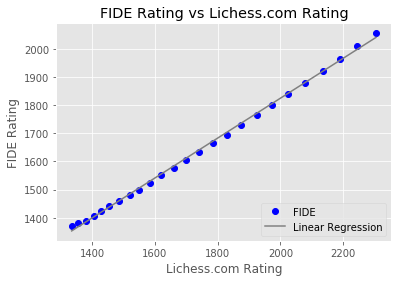

In [110]:
#import matplotlib.pyplot as plt
plt.plot(X, y, 'o',color='blue',label="FIDE")
plt.plot(X, FIDE_hat, '-k',color='gray',label="Linear Regression")
plt.title("FIDE Rating vs Lichess.com Rating")
plt.xlabel("Lichess.com Rating")
plt.ylabel("FIDE Rating")
plt.legend(loc=4)

### Create and Add Rating Difference
From the formula that we see that there is a difference in the absolute value, so we should use the difference to measure the rating. For Rating_Difference = white_rating - black_rating.

In [111]:
rating_difference = chess_pd.white_rating - chess_pd.black_rating
chess_pd = add_feature(chess_pd,'Rating_Difference',rating_difference)

chess_regression = add_feature(chess_regression, 'rating_difference', rating_difference)

# Rating_Difference is a category of type integer
print('Rating_Difference is an integer: ' +  str(type(chess_pd.Rating_Difference[0])))

Rating_Difference is an integer: <class 'numpy.int64'>


### Create Ratings Only Classification Predicter

As mentioned in the introduction, there is a simple predicter that only takes consideration of black rating and white rating.  We will now define the predicter in code as follows to find the accuracy.



In [112]:
def p_draw(white_rating, black_rating):
    '''
    Input: white_rating, black_rating
    Output: 0.048
    '''
    # In theory, p_draw is a function of white rating and black rating
    # For this assignment, however, we will have p_draw as sample draw rate
    return 0.048

def p_white(white_rating, black_rating):
    '''
    Input: white_rating, black_rating
    Output: Probability of white
    '''
    denominator = 1.0+10.0**((black_rating-white_rating)/400.0)
    p_white = 1.0/denominator - p_draw(white_rating, black_rating)/2.0
    return p_white

def p_black(white_rating, black_rating):
    '''
    Input: white_rating, black_rating
    Output: Probability of black wins
    '''
    denominator = 1.0+10.0**((white_rating-black_rating)/400.0)
    p_black = 1.0/denominator - p_draw(white_rating, black_rating)/2.0
    return p_black


def get_prediction(pwhite, pblack, pdraw):
    '''
    Input: probability of white will win, black will win, or draw
    Output: data type of largest probability (white, black, or draw)
    '''
    #prediction = []
    if (pwhite >= pblack) and (pwhite >= pdraw):
        return 'white'
    elif (pblack >= pwhite) and (pblack >= pdraw):
        return 'black'
    else:
        return 'draw'
    return prediction

    
def get_simple_prediction(white_rating, black_rating):
    '''
    Input: list of white rating, list of black rating, probability of draw,
    actual outcome
    Output: list of simple predictions
    '''
    simple_prediction = []
    for i ,val in enumerate(white_rating):
        pwhite = p_white(white_rating[i], black_rating[i])
        pblack = p_black(white_rating[i], black_rating[i])
        pdraw = p_draw(white_rating[i], black_rating[i])
        
        predict = get_prediction(pwhite, pblack, pdraw)
        simple_prediction.append(predict)
    return simple_prediction
        
def get_accuracy(prediction, actual):
    '''
    Input: list of predictions, list of outcomes
    Output: accuracy in decimal
    '''
    num_correct = 0
    num_total = 0
    for idx, val in enumerate(prediction):
        if prediction[idx] == actual[idx]:
            num_correct += 1
            num_total += 1
        else:
            num_total += 1
    return num_correct / num_total
    
simple_prediction = get_simple_prediction(chess_pd.white_rating, chess_pd.black_rating)
simple_accuracy = get_accuracy(simple_prediction, chess_pd.winner)

print('The accuracy of the ratings-only classifier is: ' + str(simple_accuracy))

The accuracy of the ratings-only classifier is: 0.6205504038288961


### Add Ratings Only Classifier Predictions


In [113]:
chess_pd = add_feature(chess_pd,'Ratings_Only_Prediction', simple_prediction)

# Don't add ratings only classifier to tsne
print('Ratings_Only_Prediction is a string: ' +  str(type(chess_pd.Ratings_Only_Prediction[0])))

Ratings_Only_Prediction is a string: <class 'str'>


## Data Quality

### Filter out Turns less than 10

If the game has less than 10 turns, it will end after 10 moves. Since we want to predict the result after first 10 moves, we have to filter out turns that less than 10.

In [114]:
def filter_short_games(df, name, num_turns):
    '''
    Input:dataframe, name of feature turns, number of turns 
    Output: dataframe, number of turns less than 10
    '''
    df = df[df[name] > num_turns]
    return df

chess_pd = filter_short_games(chess_pd, 'turns', 10)
chess_tsne = filter_short_games(chess_tsne, 'turns', 10)
chess_tsne = remove_feature(chess_tsne, 'turns')

print('Original number of games: ' + str(len(chess_original.rated)))
print('New number of games: ' + str(len(chess_pd.rated)))

Original number of games: 20058
New number of games: 19377


### Filter out Openings longer than 10

If the opening is longer than 10 moves, it may not be possible to classify.  Also, the scripted opening may not provide any value to the ML algorithm. Thus as a precuation, we will filter out all games where the opening lasts longer than the given input.


In [115]:
def filter_long_opening(df, name, num_turns):
    '''
    Input:dataframe,number of turns 
    Output: dataframe, number of turns less than 10
    '''
    df = df[df[name]<num_turns]
    return df

#chess_pd = chess_pd[-chess_pd['opening_ply']>10]
chess_pd = filter_long_opening(chess_pd, 'opening_ply', 10) 
chess_tsne = filter_long_opening(chess_tsne, 'opening_ply', 10)
print('Original number of games: ' + str(len(chess_original.rated)))
print('New number of games: ' + str(len(chess_pd.rated)))
print('New number of games: ' + str(len(chess_tsne.white_rating)))

Original number of games: 20058
New number of games: 18047
New number of games: 18047


In [116]:
chess_pd_2 = chess_pd[chess_pd['opening_ply'] > 10]
print(chess_pd_2['opening_ply'])
#print(count_all_opening(chess_pd_2['ten_moves']))

Series([], Name: opening_ply, dtype: int64)


### Examine Missing Data using Missingno


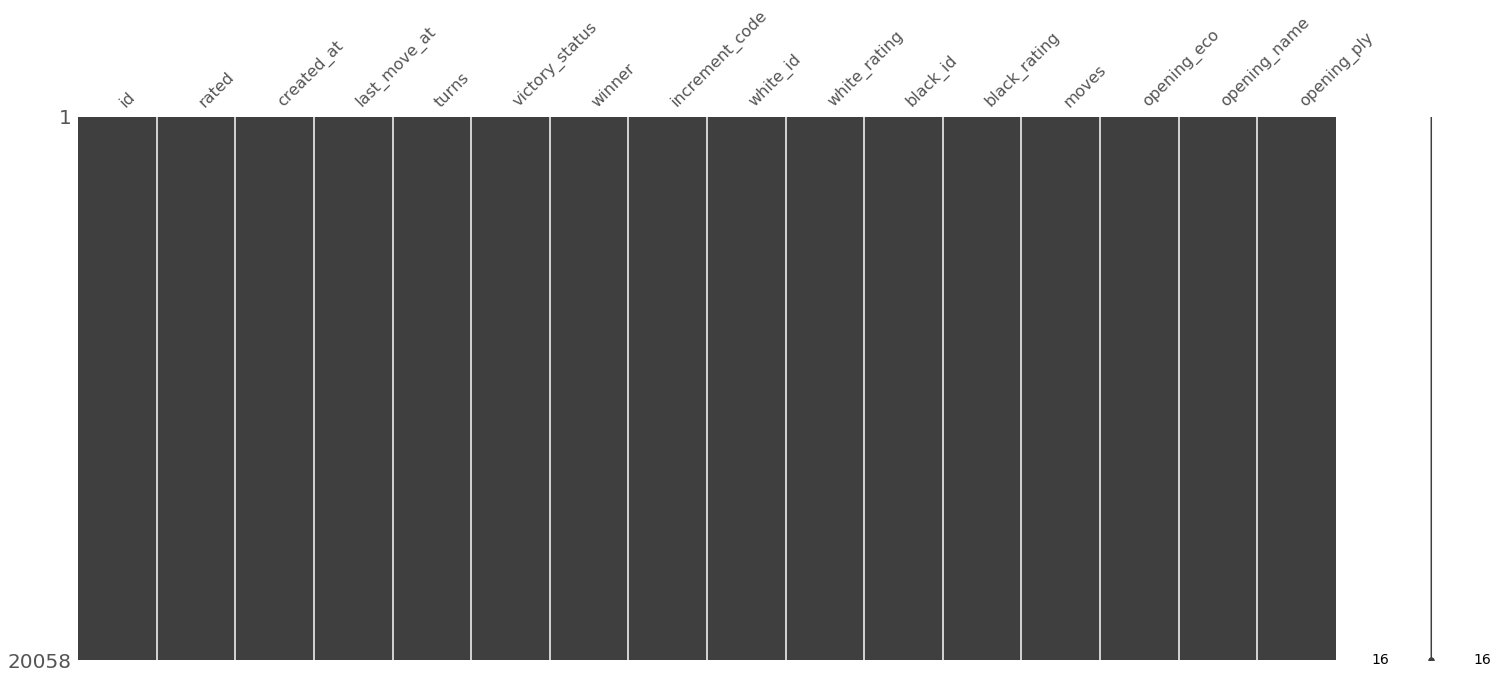

In [117]:
# This code is taken from course notebook 
#import missingno as mn
mn.matrix(chess_original.sort_values(by=["id",]))

To understand the data, the first thing to do would be to check whether there is any "NA" in the dataset. Based on the plot above, there is no missing value in the data, which is ideal for analysis.

### Add 10 Moves Separately to TSNE dataframe for visualization

In [118]:
def get_move_titles(move_list, idx):
    unique_game_openings_title=[]
    unique= np.unique(move_list)
    for game_num in range(len(unique)):
        name = str(game_num)
        name = idx + name
        unique_game_openings_title.append(name)
    return unique_game_openings_title

ten_moves = chess_pd.ten_moves

def get_x_move(move_list, num_move):
    move = []
    for game in move_list:
        move.append(game[num_move])
    return move

first = get_x_move(ten_moves, 0)
#print(first)
second = get_x_move(ten_moves, 1)
#print(second)
third = get_x_move(ten_moves, 2)
fourth = get_x_move(ten_moves, 3)
fifth = get_x_move(ten_moves, 4)
sixth = get_x_move(ten_moves, 5)
seventh = get_x_move(ten_moves, 6)
eighth = get_x_move(ten_moves, 7)
ninth = get_x_move(ten_moves, 8)
tenth = get_x_move(ten_moves, 9)          

In [119]:
chess_tsne_each_move = chess_tsne
print(chess_tsne_each_move.info())
print(np.unique(first))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18047 entries, 0 to 20057
Data columns (total 16 columns):
white_rating    18047 non-null int64
black_rating    18047 non-null int64
opening_ply     18047 non-null int64
False           18047 non-null uint8
True            18047 non-null uint8
black           18047 non-null uint8
draw            18047 non-null uint8
white           18047 non-null uint8
A               18047 non-null uint8
B               18047 non-null uint8
C               18047 non-null uint8
D               18047 non-null uint8
E               18047 non-null uint8
base            18047 non-null int64
increment       18047 non-null int64
maxtime         18047 non-null int64
dtypes: int64(6), uint8(10)
memory usage: 1.1 MB
None
['Na3' 'Nc3' 'Nf3' 'Nh3' 'a3' 'a4' 'b3' 'b4' 'c3' 'c4' 'd3' 'd4' 'e3' 'e4'
 'f3' 'f4' 'g3' 'g4' 'h3' 'h4']


In [120]:
# one hot encode for each move
one_hot_encode(chess_tsne_each_move,"first",get_move_titles(first, '1'))
#print(chess_tsne_each_move)
one_hot_encode(chess_tsne_each_move,"second",get_move_titles(second, '2'))
one_hot_encode(chess_tsne_each_move,"third",get_move_titles(third, '3'))
one_hot_encode(chess_tsne_each_move,"fourth",get_move_titles(fourth, '4'))
one_hot_encode(chess_tsne_each_move,"fifth",get_move_titles(fifth, '5'))
one_hot_encode(chess_tsne_each_move,"sixth",get_move_titles(sixth, '6'))
one_hot_encode(chess_tsne_each_move,"seventh",get_move_titles(seventh, '7'))
one_hot_encode(chess_tsne_each_move,"eighth",get_move_titles(eighth, '8'))
one_hot_encode(chess_tsne_each_move,"ninth",get_move_titles(ninth, '9'))
one_hot_encode(chess_tsne_each_move,"tenth",get_move_titles(tenth, '10'))

#print(len(unique_game_openings_title)) 
print(chess_tsne_each_move.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18047 entries, 0 to 20057
Data columns (total 16 columns):
white_rating    18047 non-null int64
black_rating    18047 non-null int64
opening_ply     18047 non-null int64
False           18047 non-null uint8
True            18047 non-null uint8
black           18047 non-null uint8
draw            18047 non-null uint8
white           18047 non-null uint8
A               18047 non-null uint8
B               18047 non-null uint8
C               18047 non-null uint8
D               18047 non-null uint8
E               18047 non-null uint8
base            18047 non-null int64
increment       18047 non-null int64
maxtime         18047 non-null int64
dtypes: int64(6), uint8(10)
memory usage: 1.1 MB
None


# NEW FOR LAB 3

# ADD SCORE OF TEN MOVES

In order to better understand who is curently winning the game, we will use a chess engine, Stockfish, to tell who is currently winning the game.  By importing stockfish and giving it the moves, Stockfish should be able to give us a positive score if white is winning and a negative score if black is winning-with the value of 1 equivalent to 1 pawn ahead. In chess, a pawn is traditionally worth 1 point, bishops and knights 3 points, rooks 5 points, and queen 9 points. For Stockfish, a positive number is good for white, while a negative number is good for black

In [123]:
# Read in Scores made Earlier different computer
chess_pd3 = pd.read_excel('/Users/yifan/Desktop/chess_pd_moves.xlsx')

# Code that was Used to create Score Data

In [124]:
# The following code is adapted from the documentation for python chess
# For this code to run, you have to have installed stockfish on your computer
#https://python-chess.readthedocs.io/en/latest/engine.html#analysing-and-evaluating-a-position
#import chess             
#import chess.engine                      

file_engine = '/Users/chandlerjburke/Documents/SMU_Masters/Fall_2019/ML_Python/stockfish-10-mac/src/stockfish'
#engine = chess.engine.SimpleEngine.popen_uci(file_engine)
def create_score(moves_list, engine, time):
    '''
    Input: moves as a list, 
    Output: score from the engine
    '''
    #engine = chess.engine.SimpleEngine.popen_uci(file_engine)
    score = []
    if (idx % 1000 == 0):
        print(idx)
    for idx, moves in enumerate(moves_list):
        board = chess.Board()
        for move in moves:
            board.push_san(move)
        info = engine.analyse(board, chess.engine.Limit(time=time))
        score.append(info['score'])
    return score

#score = create_score(ten_moves, engine, 0.05)
#print("Score:", info["score"])

# Score: +20

In [125]:
def convert_pov_int(score):
    '''
    Input: score from stockfish
    Output: integer
    '''
    if ('#' in str(score)):
        return 0
    else:
        return int(str(score))

In [126]:
def convert_all_scores(scores):
    '''
    Input: scores as a chess engine mov object
    Output: scores as a list of integers
    '''
    scores_int = []
    for score in scores:
        scores_int.append(convert_pov_int(score))
    return scores_int

#score_int = convert_all_scores(score)


# Add 10 Moves Score to chess pd, tsne

In [127]:
def filter_short_games(df, name, num_turns):
    '''
    Input:dataframe, name of feature turns, number of turns 
    Output: dataframe, number of turns less than 10
    '''
    df = df[df[name] > num_turns]
    return df

In [128]:
def filter_long_opening(df, name, num_turns):
    '''
    Input:dataframe,number of turns 
    Output: dataframe, number of turns less than 10
    '''
    df = df[df[name]<num_turns]
    return df

In [129]:
chess_pd3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 12 columns):
Unnamed: 0        20058 non-null int64
rated             20058 non-null bool
turns             20058 non-null int64
winner            20058 non-null object
increment_code    20058 non-null object
white_rating      20058 non-null int64
black_rating      20058 non-null int64
moves             20058 non-null object
opening_eco       20058 non-null object
opening_ply       20058 non-null int64
ten_moves         20058 non-null object
stockfish         20058 non-null int64
dtypes: bool(1), int64(6), object(5)
memory usage: 1.7+ MB


In [130]:
for (idx, val) in enumerate(chess_pd3['stockfish']):
    #print(idx)
    #print(val)
    arra = chess_pd3['winner']
    #print(arra[idx] == 'white')

# Calculate Statistics of Winner vs Score

In [132]:
white_win_score = []
black_win_score = []
draw_score = []

for (idx, val) in enumerate(chess_pd3['stockfish']):
    if (chess_pd3['winner'][idx] == 'white'):
        white_win_score.append(chess_pd3['stockfish'][idx])
    elif (chess_pd3['winner'][idx] == 'black'):
        black_win_score.append(chess_pd3['stockfish'][idx])
    else:
        draw_score.append(chess_pd3['stockfish'][idx])

print('Number of games White won: ' + str(len(white_win_score)))
print('Number of games Black won: ' + str(len(black_win_score)))
print('Number of games drawn: ' + str(len(draw_score)))

print('White Win Average Score: ' + str(np.round(np.mean(white_win_score))))
print('Black Win Average Score: ' + str(np.round(np.mean(black_win_score))))
print('Draw Average Score: ' + str(np.round(np.mean(draw_score))))

Number of games White won: 10001
Number of games Black won: 9107
Number of games drawn: 950
White Win Average Score: 117.0
Black Win Average Score: 43.0
Draw Average Score: 81.0


This data is eactly as we expected.  When white wins, white has an advantage and is a large positive number.  When black wins the score is close to zero.  When there is a draw, the average score is between when black wins and when white wins.

# Boxplot of White Win vs. Black Win vs. Draw

{'whiskers': [<matplotlib.lines.Line2D at 0x1a29fa7f28>,
 'caps': [<matplotlib.lines.Line2D at 0x1a29fc03c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a29fa7be0>],
 'medians': [<matplotlib.lines.Line2D at 0x1a29fc0a58>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a29fc0da0>],
 'means': []}

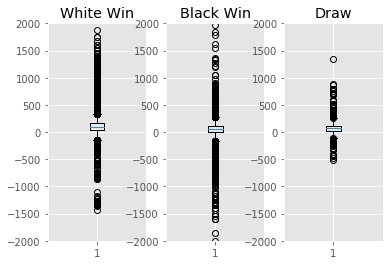

In [133]:
# Documentation for box plot https://matplotlib.org/api/_as_gen/matplotlib.pyplot.boxplot.html#matplotlib.pyplot.boxplot

plt.figure()
#fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey = True)

plt.subplot(1,3,1)
plt.ylim([-2000, 2000])
plt.boxplot(white_win_score)
plt.title('White Win')

plt.subplot(1,3,2)
plt.ylim([-2000, 2000])
plt.title('Black Win')
plt.boxplot(black_win_score)

plt.subplot(1,3,3)
plt.ylim([-2000, 2000])
plt.title('Draw')
plt.boxplot(draw_score)

From this boxplot we can see that when White wins, the scores skew positive. When black wins the scores skew negative. When there is a draw the scores tend to be around zero and there are fewer outliers. This is exactly what we would expect.  Thus, this data is correlated with a white win and should be helpful to predict the outcome of the chess match.

# Verify Length of Dataframe is correct

In [134]:
print(len(chess_pd3['stockfish']))
chess_pd3 = filter_short_games(chess_pd3, 'turns', 10)
print(len(chess_pd3['turns']))

chess_pd3 = filter_long_opening(chess_pd3, 'opening_ply', 10)
print(len(chess_pd3['turns']))


20058
19377
18047


# Divide Data into 80% train test split (5 Points)

In [135]:
print(chess_regression)

       turns winner  white_rating  black_rating  opening_ply  False  True  A  \
0         13  white          1500          1191            5      1     0  0   
1         16  black          1322          1261            4      0     1  0   
2         61  white          1496          1500            3      0     1  0   
3         61  white          1439          1454            3      0     1  0   
4         95  white          1523          1469            5      0     1  0   
5          5   draw          1250          1002            4      1     0  0   
6         33  white          1520          1423           10      0     1  0   
7          9  black          1413          2108            5      1     0  0   
8         66  black          1439          1392            6      0     1  0   
9        119  white          1381          1209            4      0     1  0   
10        39  white          1381          1272            1      1     0  1   
11        38  black          1381       

# Create Dataframes for Logistic Regression Dataframe

## Create Dataframe that includes all variables

The chess_regression dataframe inlcudes all information that would be known to a gambler after 10 moves of a chess game. These include the rating of the white player, rating of the black player, length of opening, true if rated game, false if non-rated game, the category of the opening, the base time, the increment time, the maxtime which is the average maximum time for the game, the ratings difference between white and black, and the score of the game from stockfish where score is positive if white is winning and negative if black is winnning. 

In [136]:
chess_regression = chess_tsne

# Actual Values
chess_regression = remove_feature(chess_regression, 'black')
chess_regression = remove_feature(chess_regression, 'draw')
chess_regression = remove_feature(chess_regression, 'white')
chess_regression = remove_feature(chess_regression, 'winner')

chess_regression = add_feature(chess_regression, 'opening_ply', chess_pd['opening_ply'])
chess_regression = add_feature(chess_regression, "ratings_difference", chess_pd['Rating_Difference'])

chess_regression = add_feature(chess_regression, 'stockfish', chess_pd3['stockfish'])

#chess_regression = remove_feature(chess_regression, '0')
#chess_regression = remove_feature(chess_regression, 'turns')
#chess_regression = remove_feature(chess_regression, 'winner')
#chess_regression = remove_feature(chess_regression, 'moves')
#chess_regression = remove_feature(chess_regression, 'opening_eco'

In [137]:
print(chess_regression.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18047 entries, 0 to 20057
Data columns (total 15 columns):
white_rating          18047 non-null int64
black_rating          18047 non-null int64
opening_ply           18047 non-null int64
False                 18047 non-null uint8
True                  18047 non-null uint8
A                     18047 non-null uint8
B                     18047 non-null uint8
C                     18047 non-null uint8
D                     18047 non-null uint8
E                     18047 non-null uint8
base                  18047 non-null int64
increment             18047 non-null int64
maxtime               18047 non-null int64
ratings_difference    18047 non-null int64
stockfish             18047 non-null int64
dtypes: int64(8), uint8(7)
memory usage: 1.4 MB
None


# Standardize

In [138]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scale_var = ["white_rating","black_rating","base","increment","maxtime","ratings_difference","stockfish"]
scaler.fit(chess_regression[scale_var])
chess_scale = pd.DataFrame(scaler.transform(chess_regression[scale_var]),columns=scale_var) 

for i in range(len(scale_var)):
    chess_regression=remove_feature(chess_regression,scale_var[i])

# rename index 
chess_scale.index = chess_regression.index
chess_regression = pd.concat([chess_regression,chess_scale],axis=1)

## Create Dataframe that only has 7 variables (it runs faster)

We also made a simple dataframe that includes smaller number of variables of only the variables that we suspect actually matter. We know that the ratings of the players matter, and we hope that the other variables assist in making an accurate prediction. 
The chess_simple dataframe again inlcudes some information that would be known to a gambler after 10 moves of a chess game. These include the rating of the white player, rating of the black player, true if rated game, false if non-rated game, the maxtime which is the average maximum time for the game, the ratings difference between white and black, and the score of the game from stockfish where score is positive if white is winning and negative if black is winnning. 

In [139]:
chess_simple = chess_regression
chess_simple = remove_feature(chess_simple, 'opening_ply')
chess_simple = remove_feature(chess_simple, 'False')
chess_simple = remove_feature(chess_simple, 'True')
chess_simple = remove_feature(chess_simple, 'A')
chess_simple = remove_feature(chess_simple, 'B')
chess_simple = remove_feature(chess_simple, 'C')
chess_simple = remove_feature(chess_simple, 'D')
chess_simple = remove_feature(chess_simple, 'E')
chess_simple = remove_feature(chess_simple, 'base')
chess_simple = remove_feature(chess_simple, 'increment')
chess_simple.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18047 entries, 0 to 20057
Data columns (total 7 columns):
False                 18047 non-null uint8
True                  18047 non-null uint8
white_rating          18047 non-null float64
black_rating          18047 non-null float64
maxtime               18047 non-null float64
ratings_difference    18047 non-null float64
stockfish             18047 non-null float64
dtypes: float64(5), uint8(2)
memory usage: 881.2 KB


## Create Dataframe with only 3 variables for testing (it runs faster)
  
We also made an even simpler dataframe that includes just the chess_rating differnce. We know that the ratings of the players matter, and we hope that the other variables assist in making an accurate prediction, as a classifier only using the ratings of the players performs 62%. 
The chess_rating dataframe aonly includes rating difference.

In [140]:
df1 = chess_simple['ratings_difference']
df2 = chess_simple['stockfish']

chess_rating = pd.concat([df1, df2],axis=1)
chess_rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18047 entries, 0 to 20057
Data columns (total 2 columns):
ratings_difference    18047 non-null float64
stockfish             18047 non-null float64
dtypes: float64(2)
memory usage: 423.0 KB


In [302]:
def get_labels(feature):

    labels = []
    for dirc in feature:
        if dirc == "white" :
            label = 1
        elif dirc =="black" :
            label = -1
        elif dirc =="draw" :
            label = 0
        labels.append(label)
    labels = np.array(labels)
    return labels
chess_labels = get_labels(chess_pd3['winner'])

## Train Test split for full model

In [368]:
X_train, X_test, y_train, y_test = train_test_split(chess_regression,chess_labels,test_size=0.2)

In [369]:
y_train

array([ 1,  1, -1, ...,  1,  0,  1])

In [305]:
y_test

array([-1, -1,  1, ..., -1,  1,  1])

## Train Test split for model with 7 variables

In [306]:
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(chess_simple,chess_labels,test_size=0.2)

## Train Test split for model with 3 variables

In [336]:
X_train_rating, X_test_rating, y_train_rating, y_test_rating = train_test_split(chess_rating,chess_labels,test_size=0.2)

# Explanation for an 80/20 split

The data is divided using an 80% training and 20% testing split since it is a classic way to split the data set. We specify the training data set to be 80% of the data to ensure we have a large sample size. Presence of more data will result in better and accurate models, while reducing the training data will get risk of losing important patterns/ trends in data set. We should also have enough data for testing to reduce the test variance, so we split 20% of data to test our model. It is a tradeoff for us to split the data set as larger sample size for training can improve the predictive model but will increase the test variance simutaneously, so an 80/20 split is appropriate.

### Reference

Ray, Sunil, and Business Analytics. “8 Proven Ways for Boosting the ‘Accuracy’ of a Machine Learning Model.” Analytics Vidhya, 25 June 2019, https://www.analyticsvidhya.com/blog/2015/12/improve-machine-learning-results/.

# Cross Validation is better for our Train and Test Split


In [337]:
print(chess_pd3.winner.value_counts())

white    8972
black    8253
draw      822
Name: winner, dtype: int64


From the counts of three categories, the sample size is small for 'draw' since there are only 822 samples. So after an 80/20 split, there are only 160 samples of draw for the test set. It is not enough, and we can get almost any performance on this set only due to chance. In K Fold cross validation, the data is divided into k subsets. Now the holdout method is repeated k times, such that each time, one of the k subsets is used as the test set/ validation set and the other k-1 subsets are put together to form a training set. The error estimation is averaged over all k trials to get total effectiveness of our model. As can be seen, every data point gets to be in a validation set exactly once, and gets to be in a training set k-1 times. This significantly reduces bias as we are using most of the data for fitting, and also significantly reduces variance as most of the data is also being used in validation set. As a general rule and empirical evidence, K = 5 or 10 is generally preferred as it is often reported that the optimal k is between 5 and 10 , because the statistical performance does not increase a lot for larger values of k. So for our problem, using a 5/10 fold cross validation method to do an 80/20 split is a better way.

### Reference

Arlot, Sylvain, and Alain Celisse. “A Survey of Cross-Validation Procedures for Model Selection.” Statistics Surveys, The Author, under a Creative Commons Attribution License, https://projecteuclid.org/download/pdfview_1/euclid.ssu/1268143839.

Gupta, Prashant. “Cross-Validation in Machine Learning.” Medium, Towards Data Science, 5 June 2017, https://towardsdatascience.com/cross-validation-in-machine-learning-72924a69872f.

Shulga, Dima. “5 Reasons Why You Should Use Cross-Validation in Your Data Science Projects.” Medium, Towards Data Science, 27 Sept. 2018, https://towardsdatascience.com/5-reasons-why-you-should-use-cross-validation-in-your-data-science-project-8163311a1e79.

# Modeling (50 Points)

In [ ]:
%%time
# from last time, our logistic regression algorithm is given by (including everything we previously had):
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
 

In [437]:
   
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient

___

Now let's add the model training function, using the update equation defined previously:

$$ \mathbf{w} \leftarrow \mathbf{w} + \eta \frac{1}{M}\sum_{i=1}^M (y^{(i)}-g(\mathbf{w}^T\mathbf{x}^{(i)}))\mathbf{x}^{(i)} $$

In [370]:
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 

            
# solver support: steepest_descent, stochastic_gradient_descent, newton_method
# penalty support: none, l1, l2, l1l2
class SuperBinaryLogisticRegression(BinaryLogisticRegression):
    def __init__(self, eta, solver="steepest_descent", penalty="none", iterations=20, C=0.001):
        self.eta = eta
        self.solver = solver
        self.penalty = penalty
        self.iters = iterations
        self.C = C
        # internally we will store the weights as self.w_ to keep with sklearn conventions

    def _optimization_process(self, X, y):
        if "steepest_descent" == self.solver:
            ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
            gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
            gradient = gradient.reshape(self.w_.shape)
            return gradient
        
        elif "stochastic_gradient_descent" == self.solver:
            idx = int(np.random.rand()*len(y)) # grab random instance: add a random select process to the steepest descent
            ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
            gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
            gradient = gradient.reshape(self.w_.shape)
            return gradient
        
        elif "newton_method" == self.solver: # Hessian
            g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
            hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian
            ydiff = y-g # get y difference
            gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
            gradient = gradient.reshape(self.w_.shape)
            gradient[1:] += -2 * self.w_[1:] * self.C
            return pinv(hessian) @ gradient
        elif "mse" == self.solver:
            g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
            hessian = (-2/len(y))*X.T@np.diag(y*g-3*y*g**2+2*y*g**3-2*g**2+5*g**3-3*g**4)@X - 2 * self.C# calculate the hessian
            ydiff = y-g # get y difference
            gradient = np.sum(X * ydiff[:,np.newaxis]*(1-g)[:,np.newaxis]*g[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
            gradient = gradient.reshape(self.w_.shape)
            gradient[1:] += -2 * self.w_[1:] * self.C
            gradient = np.linalg.pinv(hessian) @ gradient
            return gradient
        
        else:
            raise ValueError('Not support solver parameter:', self.solver)
            
    def _penalization_process(self, gradient):
        if "none" == self.penalty:
            return gradient

        elif "l1" == self.penalty:
            gradient[1:] += np.sign(self.w_[1:]) * self.C
            return gradient
        
        elif "l2" == self.penalty:
            gradient[1:] += -2 * self.w_[1:] * self.C
            return gradient
        
        elif "l1l2" == self.penalty:
            gradient[1:] += (np.sign(self.w_[1:]) * self.C) + (-2 * self.w_[1:] * self.C)
            return gradient
        
        else:
            raise ValueError('Not support penalty parameter:', self.penalty)
    
    def _get_gradient(self,X,y):
        gradient = self._optimization_process(X,y)
        gradient = self._penalization_process(gradient)
        return gradient

CPU times: user 48 µs, sys: 1 µs, total: 49 µs
Wall time: 52 µs


In [435]:
class MultiClassSuperLogisticRegression:
    def __init__(self, eta, solver="steepest_descent", penalty="none", iterations=5, C=0.01):
        self.eta = eta
        self.solver = solver
        self.penalty = penalty
        self.iters = iterations
        self.C = C
        self.classifiers_ = []
    
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            sblr = SuperBinaryLogisticRegression(self.eta,self.solver,self.penalty,self.iters,self.C)
            sblr.fit(X,y_binary)
            #print(accuracy(y_binary,sblr.predict(X)))
            # add the trained classifier to the list
            self.classifiers_.append(sblr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

    def predict_proba(self,X):
        probs = []
        for sblr in self.classifiers_:
            probs.append(sblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return [self.unique_[argmax] for argmax in np.argmax(self.predict_proba(X),axis=1)]

                
mcslr = MultiClassSuperLogisticRegression(eta=0.1,solver="steepest_descent",penalty="l2",iterations=100,C=0.01)
mcslr.fit(X_train, y_train)
yhat = mcslr.predict(X_test)
accuracy = accuracy_score(y_test,yhat)
print(accuracy)

0.6396121883656509


In [388]:
solver_list = ["steepest_descent", "stochastic_gradient_descent","newton_method","mse"]
penalty_list = ["none", "l1", "l2", "l1l2"]
C_list = np.geomspace(0.01, 100, num=6)
accuracy_list = {}

for solver in solver_list:
    accuracy_list[solver] = {}
    for penalty in penalty_list:
        accuracy_list[solver][penalty] = []
        for C in C_list:
            iter = 5
            lr = MultiClassSuperLogisticRegression(eta=0.1,solver=solver,penalty=penalty,iterations=iter,C=C)
            lr.fit(X_train, y_train)
            yhat = lr.predict(X_test)
            accuracy = accuracy_score(y_test, yhat)
            accuracy_list[solver][penalty].append(accuracy)

In [389]:
accuracy_list

{'steepest_descent': {'none': [0.6055401662049862,
   0.6055401662049862,
   0.6055401662049862,
   0.6055401662049862,
   0.6055401662049862,
   0.6055401662049862],
  'l1': [0.6049861495844875,
   0.5997229916897507,
   0.5800554016620498,
   0.5484764542936288,
   0.5254847645429362,
   0.5210526315789473],
  'l2': [0.6052631578947368,
   0.6047091412742382,
   0.6013850415512465,
   0.5720221606648199,
   0.5047091412742383,
   0.6141274238227147],
  'l1l2': [0.6049861495844875,
   0.5986149584487535,
   0.5792243767313019,
   0.5512465373961218,
   0.3601108033240997,
   0.43518005540166205]},
 'stochastic_gradient_descent': {'none': [0.45263157894736844,
   0.4595567867036011,
   0.46565096952908586,
   0.5185595567867036,
   0.5742382271468144,
   0.5393351800554017],
  'l1': [0.4969529085872576,
   0.49390581717451526,
   0.52797783933518,
   0.4332409972299169,
   0.4922437673130194,
   0.4551246537396122],
  'l2': [0.6141274238227147,
   0.4659279778393352,
   0.4952908587257

Max Accuracy for each solver:
steepest_descent none : C= 0.06309573444801933 , Accuracy = 0.6055401662049862
stochastic_gradient_descent l2 : C= 0.06309573444801933 , Accuracy = 0.6141274238227147
newton_method none : C= 0.01 , Accuracy = 0.6404432132963989
mse l1l2 : C= 0.01 , Accuracy = 0.6349030470914128


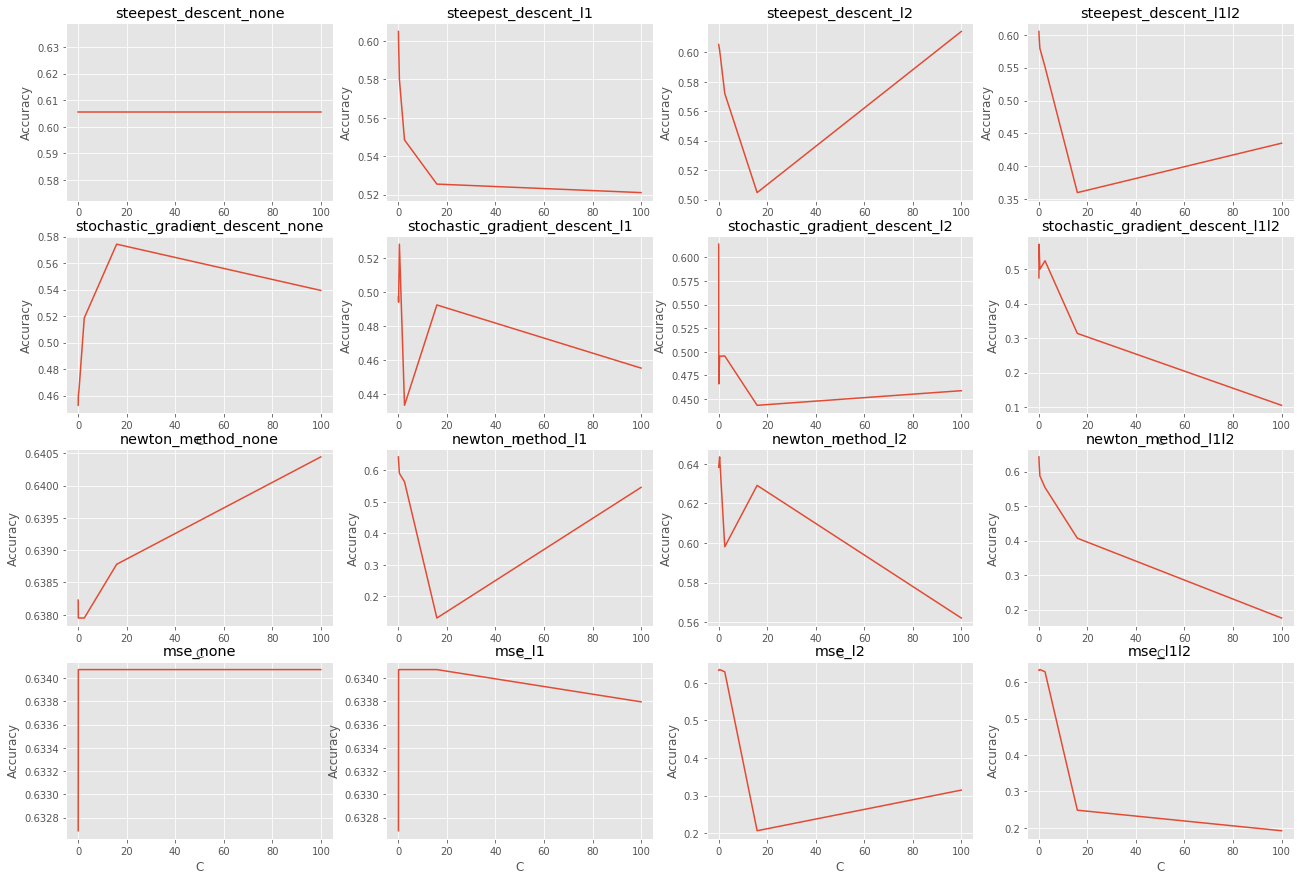

In [403]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(22,15))

i = 0
for solver in accuracy_list:
    lines = []
    j = 0
    for penalty in accuracy_list[solver]:
        plt.subplot(len(solver_list),len(penalty_list),4*i+j+1)
        plt.xlabel("C")
        plt.ylabel("Accuracy")
        plt.title(solver + "_" + penalty)
        plt.plot(C_list, accuracy_list[solver][penalty])
        j = j + 1
    i = i + 1

#print max value
print("Max Accuracy for each solver:")
print(solver_list[0], penalty_list[0] ,": C=", C_list[1], ", Accuracy =", accuracy_list["steepest_descent"]["none"][1])

print(solver_list[1], penalty_list[2] ,": C=", C_list[1], ", Accuracy =", accuracy_list["stochastic_gradient_descent"]["l2"][0])

print(solver_list[2], penalty_list[0] ,": C=", C_list[0], ", Accuracy =", accuracy_list["newton_method"]["none"][5])

print(solver_list[3], penalty_list[3] ,": C=", C_list[0], ", Accuracy =", accuracy_list["mse"]["l1l2"][2])


# Dataset Chosen for Classification-Performance

From looking at the performance of sci-kit learn on chess_regression, we tried to replicate this performance on our functions. However, we received very poor performance as we found accuracies commonly below 20%.  We are unsure why our functions could perform decently well on IRIS but not on the chess dataset.  We also noticed that 62% is essentially the exact same as the performance of the dataset that only looks at white rating and black rating.  This is rather unfortunate as we were hoping that a classification model that included other parameters (especially the score of the game after 10 moves) would outperform a model that only looked at the rating difference. We did realize that if the other data is too noisy and is basically uncorrelated with the data, it would probably make the model worse.  Thus, we made two other regression dataframes with fewer variables that we thought would be more correlated with winning.  With these new datasets, sci-kit learn also performed at a rate of around 62%, while our logistic regression model continued to suck in both time and accuracy. We do not know if sci-kit learn is employing some sophisticated algorithm such as gear-shifting or other dynamic choice of eta to perform faster iteration time or random-weight selection to escape local minima and 'hop around.'  


## Data Snooping

   Data snooping occurs when a given set of data is used more than once for purposes of inference or model selection. When such data reuse occurs, there is always the possibility that any satisfactory results obtained may simply be due to chance rather than to any merit inherent in the method yielding the results.

   Almost every machine learning practitioner understands the principle of separating training data from validation and testing data when constructing machine learning models.However, simply partitioning data into training and testing subsets may not sufficiently prevent test or validation data from influencing the training of a model.
   
   All of the available X data was provided to the standard scaler which used the mean, maximum, and minimums of the numeric data to scale the numeric data across the entire X data set. A subset of the scaled data (X_train) was used to train the model. The scaled data included the data that was to become part of the test data used to generate predictions for evaluation. The scaler has “snooped” data that should not be available for training. The test data influences the mean, maximum and minimum values used during the scaling operation.To remedy the data snooping problem, the training data should be scaled independently of the test data.

### Reference:
Keyes, Chip. “Are You Unknowingly Data Snooping When Training Your ML Models?” Medium, Medium, 15 Feb. 2019, https://medium.com/@chipk215/are-you-unknowingly-data-snooping-when-training-your-ml-models-7d6a70bdff1b.

White, Halbert. “A Reality Check for Data Snooping.” Wiley Online Library, John Wiley & Sons, Ltd (10.1111), 10 Dec. 2003, https://onlinelibrary.wiley.com/doi/abs/10.1111/1468-0262.00152.

# Our best model

In [426]:
%%time
eta = 0.1
iter = 5
solver = 'newton_method'
penalty = 'none'
C = 0.01

X_test_guess = X_test
y_test_guess = y_test
X_train_guess = X_train
y_train_guess = y_train

lr = MultiClassSuperLogisticRegression(eta=eta,solver=solver,penalty=penalty,iterations=iter,C=C)
lr.fit(X_train_guess, y_train_guess)
yhat = lr.predict(X_test)
accuracy = accuracy_score(y_test, yhat)
print('Accuracy of full regression using our best model: ' + str(accuracy))

Accuracy of full regression using our best model: 0.6382271468144044
CPU times: user 15 s, sys: 9.85 s, total: 24.9 s
Wall time: 6.49 s


# Compare to Sci-Kit Learn for each solver of sci-kit Learn

# Scikit Learn LBFGS

In [408]:
from sklearn.linear_model import LogisticRegression

def sklearn_logistic(solver, X, y):
    if (solver != 'liblinear'):
        sk = LogisticRegression(solver = solver, multi_class = 'multinomial').fit(X,y)
    else:
        sk = LogisticRegression(solver = solver).fit(X,y)
    return sk

def get_accuracy(y, y_hat):
    '''
    Input: y, yhat
    Output: accuracy
    '''
    total = len(y)
    right = 0
    for idx, val in enumerate(y):
        if y[idx] == y_hat[idx]:
            right += 1
    return right/total

In [409]:
sk = sklearn_logistic('lbfgs', X_train, y_train)
y_hat = sk.predict(X_test)

acc = get_accuracy(list(y_test),list(y_hat))
print('Accuracy of full regression using sci-kit learn lbfgs: ' + str(acc))


Accuracy of full regression using sci-kit learn lbfgs: 0.6362880886426593


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


# Scikit Learn Newton

In [410]:
sk = sklearn_logistic('newton-cg', X_train, y_train)
y_hat = sk.predict(X_test)
acc = get_accuracy(list(y_test),list(y_hat))
print('Accuracy of full regression using sci-kit learn newton-cg: ' + str(acc))


Accuracy of full regression using sci-kit learn newton-cg: 0.6357340720221607


# Scikit Learn Linear

In [411]:
sk = sklearn_logistic('liblinear', X_train, y_train)
y_hat = sk.predict(X_test)

acc = get_accuracy(list(y_test),list(y_hat))
print('Accuracy of full regression using sci-kit learn liblinear: ' + str(acc))

#print('Accuracy of: ',accuracy_score(y,yhat))

Accuracy of full regression using sci-kit learn liblinear: 0.6365650969529086


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


## Compare Sci-Kit Learn for the simpler Regression Dataframes


In [412]:
# Compare Sci-Kit Learn for the simpler Regression Dataframes
sk = sklearn_logistic('liblinear', X_train_simple, y_train_simple)
y_hat = sk.predict(X_test_simple)

acc = get_accuracy(list(y_test_simple),list(y_hat))
print('Accuracy of 7 variable using sci-kit learn liblinear: ' + str(acc))


Accuracy of 7 variable using sci-kit learn liblinear: 0.632409972299169


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [413]:
# Compare Sci-Kit Learn for the simpler Regression Dataframes
sk = sklearn_logistic('liblinear', X_train_rating, y_train_rating)
y_hat = sk.predict(X_test_rating)

acc = get_accuracy(list(y_test_rating),list(y_hat))
print('Accuracy of 4 variable using sci-kit learn liblinear: ' + str(acc))


Accuracy of 4 variable using sci-kit learn liblinear: 0.62797783933518


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


## Compare Performance of our best logistic regression to sci-kit learn


# Sci Kit Learn Best

In [420]:
%%time
sk = sklearn_logistic('liblinear', X_train_rating, y_train_rating)
y_hat_scikit = sk.predict(X_test_rating)
scikit_acc = get_accuracy(list(y_test_rating),list(y_hat_scikit))
scikit_acc

CPU times: user 25.2 ms, sys: 1.63 ms, total: 26.8 ms
Wall time: 25.6 ms


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.62797783933518

Text(0.5, 1.0, 'Comparison of Accuracy')

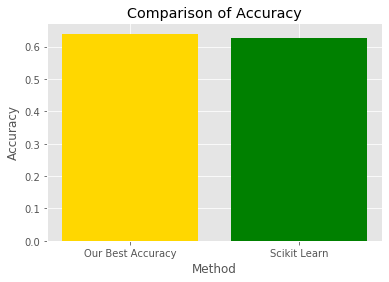

In [421]:
# Hard code our best accuracy found from randomized grid search
our_best_acc = 0.64

import matplotlib.pyplot as plt
plt.subplot()
lable = ['Our Best Accuracy','Scikit Learn']
accuracy = [our_best_acc, scikit_acc]
colors = ['gold', 'green']
plt.bar(lable, accuracy,color=colors)
plt.xlabel("Method")
plt.ylabel("Accuracy")
plt.title("Comparison of Accuracy")

From the result we got before and the bar plot above, the accuracy of Scikit Learn is 20% higher than our best accuracy (with Newton Method). The reason of this is probably because the optimizations of Scikit Learn is better in applicaiton for this data set.

Text(0.5, 1.0, 'Comparison of Time')

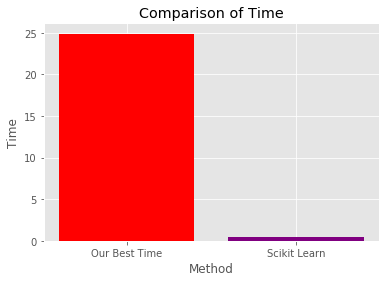

In [427]:
plt.subplot()
lable = ['Our Best Time','Scikit Learn']
time = [24.9, 26.8/60]
colors = ['red', 'purple']
plt.bar(lable, time,color=colors)
plt.xlabel("Method")
plt.ylabel("Time")
plt.title("Comparison of Time")

From the result we got before and the bar plot above, the time of Scikit Learn is faster than our best time (with Newton Method).

# Deployment (10 Points)

From the source of scikit-learn, we can tell it has 90.5 kB, over 2000 lines, which may cause problems in the old days. But scikit-learn has higher accuracy on the test set(accuracy is compared with in our implementation), and run much faster( compared with in our implementation). We suggest to use scikit-learn.

## MSE Explanation

Based on the results above, MSE have worse accuracy among other methods. There are several results.

From the basics of statistical machine learning, the loss function is the negative-log-likelihood of the model. To find the best parameters, we need to minimize this NLL loss. The MSE is the NLL for the linear regression model (with Gaussian likelihood). But for the logistic regression model, the NLL is the cross-entropy (with Bernoulli likelihood). So minimizing the MSE loss for a logistic regression model is minimizing something else other than the NLL of that model. 

Besides, MLE is a more attractive option. First,it is more computational efficiency. Learning parameters for any machine learning model (such as logistic regression) is much easier if the cost function is convex. And, it's not too difficult to show that, for logistic regression, the cost function for the mean square error is not convex, while the cost function for the log-likelihood is. Secondly, MLE has very nice properties such: consistency: meaning that with more data, our estimate of w gets closer to the true value; asymptotic normality: meaning that with more data, our estimate of w is approximately normal distributed with variance that decreases with 𝑂(1𝑛); functional invariance: nice property to have when dealing with multiple parameters (nuisance parameters) and calculating the profile likelihood. 

## Citation

Pinninti, Harsha, and Sri Harsha PinnintiSri Harsha Pinninti. “Why Sum of Squared Errors for Logistic Regression Not Used and Instead Maximum Likelihood Estimation Is Used to Fit the Model?” Cross Validated, 1 Mar. 1967, https://stats.stackexchange.com/questions/251496/why-sum-of-squared-errors-for-logistic-regression-not-used-and-instead-maximum-l.

“What Are the Main Reasons Not to Use MSE as a Cost Function for Logistic Regression?” Quora, https://www.quora.com/What-are-the-main-reasons-not-to-use-MSE-as-a-cost-function-for-Logistic-Regression.
